In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
import plotly

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
#import os
#os.chdir('../input/Data/Stocks/')

In [84]:
#저가, 수익률, 시가총액, 상장주식수, 거래량, 기준가 순서임
data = pd.read_csv('C:\\Users\\건우\\Desktop\\금융분석.csv')
data.head()

,Symbol Name,KB금융,KB금융.1,KB금융.2,KB금융.3,KB금융.4,KB금융.5,신한지주,신한지주.1,신한지주.2,...,SK디앤디.4,SK디앤디.5,한화손해보험,한화손해보험.1,한화손해보험.2,한화손해보험.3,한화손해보험.4,한화손해보험.5,Unnamed: 145,Unnamed: 146
0,2021-06-18,56100.0,-0.18,23617890.0,415807920.0,1240029.0,56900.0,41050.0,-1.32,21232242.0,...,36426.0,35800.0,4595.0,1.93,555677.0,116738915.0,576970.0,4670.0,NaN,KB금융
1,2021-06-17,56300.0,0.00,23659471.0,415807920.0,1208470.0,56900.0,41650.0,-0.83,21516371.0,...,29555.0,35800.0,4655.0,-1.58,545171.0,116738915.0,620770.0,4745.0,NaN,KB금융
2,2021-06-16,55900.0,1.79,23659471.0,415807920.0,1172338.0,55900.0,41150.0,1.94,21697181.0,...,47008.0,35500.0,4595.0,3.49,553926.0,116738915.0,1232241.0,4585.0,NaN,KB금융
3,2021-06-15,55400.0,-0.53,23243663.0,415807920.0,950322.0,56200.0,40700.0,0.12,21283902.0,...,49210.0,35400.0,4460.0,1.78,535248.0,116738915.0,499791.0,4505.0,NaN,KB금융
4,2021-06-14,55700.0,-1.40,23368405.0,415807920.0,1080418.0,57000.0,41000.0,-2.72,21258072.0,...,40701.0,35100.0,4485.0,-1.31,525909.0,116738915.0,596901.0,4565.0,NaN,신한지주


In [114]:
data.columns

Index(['Symbol Name', 'KB금융', 'KB금융.1', 'KB금융.2', 'KB금융.3', 'KB금융.4', 'KB금융.5',
       '신한지주', '신한지주.1', '신한지주.2',
       ...
       'SK디앤디.4', 'SK디앤디.5', '한화손해보험', '한화손해보험.1', '한화손해보험.2', '한화손해보험.3',
       '한화손해보험.4', '한화손해보험.5', 'Unnamed: 145', 'Unnamed: 146'],
      dtype='object', length=147)

In [252]:
#파일 불러오기
a = '삼성증권'
data_kb = pd.DataFrame(data[['Symbol Name',a]])
data_kb.head()

,Symbol Name,삼성증권
0,2021-06-18,44550.0
1,2021-06-17,44750.0
2,2021-06-16,45050.0
3,2021-06-15,44650.0
4,2021-06-14,44550.0


            Symbol Name     삼성증권
Adjustments                     
2021-06-18   2021-06-18  44550.0
2021-06-17   2021-06-17  44750.0
2021-06-16   2021-06-16  45050.0
2021-06-15   2021-06-15  44650.0
2021-06-14   2021-06-14  44550.0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49340 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49457 missing from cur

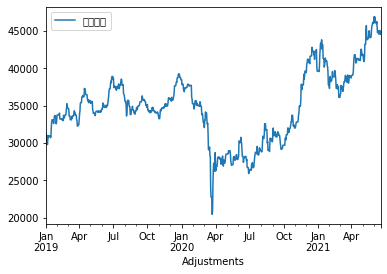

In [253]:
from pandas.tseries.offsets import MonthEnd 

data_kb['Adjustments'] = pd.to_datetime(data_kb['Symbol Name']) 
data_kb = data_kb.set_index('Adjustments') 
print(data_kb.head()) 
data_kb.plot()

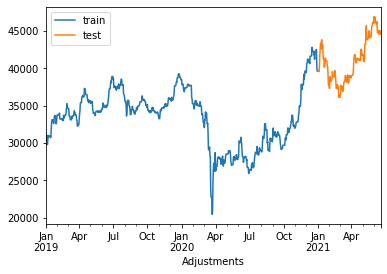

In [254]:
split_date = pd.Timestamp('01-01-2021')
# 2011/1/1 까지의 데이터를 트레이닝셋.
# 그 이후 데이터를 테스트셋으로 한다.

train = data_kb.loc[split_date:, [a]]
test = data_kb.loc[:split_date, [a]]
# Feature는 Unadjusted 한 개

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [255]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc


array([[0.85682327],
       [0.85682327],
       [0.85682327],
       [0.8836689 ],
       [0.98657718],
       [0.9753915 ],
       [0.9753915 ],
       [0.9753915 ],
       [0.9753915 ],
       [0.92841163],
       [0.95973154],
       [0.95525727],
       [0.9753915 ],
       [0.9753915 ],
       [0.9753915 ],
       [0.98434004],
       [1.        ],
       [0.94854586],
       [0.94854586],
       [0.94630872],
       [0.94630872],
       [0.94630872],
       [0.901566  ],
       [0.91498881],
       [0.9082774 ],
       [0.9261745 ],
       [0.92841163],
       [0.92841163],
       [0.92841163],
       [0.90604027],
       [0.901566  ],
       [0.85682327],
       [0.84787472],
       [0.85682327],
       [0.85682327],
       [0.85682327],
       [0.82550336],
       [0.80760626],
       [0.83892617],
       [0.77404922],
       [0.77628635],
       [0.77628635],
       [0.77628635],
       [0.74720358],
       [0.77852349],
       [0.77628635],
       [0.68680089],
       [0.646

In [256]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df

,Scaled
Adjustments,
2021-01-01,0.856823
2020-12-31,0.856823
2020-12-30,0.856823
2020-12-29,0.883669
2020-12-28,0.986577
...,...
2019-01-05,0.418345
2019-01-04,0.418345
2019-01-03,0.429530


In [257]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
2021-01-01,0.856823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,0.856823,0.856823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-30,0.856823,0.856823,0.856823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,0.883669,0.856823,0.856823,0.856823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,0.986577,0.883669,0.856823,0.856823,0.856823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-27,0.975391,0.986577,0.883669,0.856823,0.856823,0.856823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26,0.975391,0.975391,0.986577,0.883669,0.856823,0.856823,0.856823,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-25,0.975391,0.975391,0.975391,0.986577,0.883669,0.856823,0.856823,0.856823,NaN,NaN,NaN,NaN,NaN
2020-12-24,0.975391,0.975391,0.975391,0.975391,0.986577,0.883669,0.856823,0.856823,0.856823,NaN,NaN,NaN,NaN


In [258]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]


In [259]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)

(720, 12)
[[0.95525727 0.95973154 0.92841163 ... 0.85682327 0.85682327 0.85682327]
 [0.9753915  0.95525727 0.95973154 ... 0.8836689  0.85682327 0.85682327]
 [0.9753915  0.9753915  0.95525727 ... 0.98657718 0.8836689  0.85682327]
 ...
 [0.41834452 0.41834452 0.41834452 ... 0.46979866 0.45861298 0.46308725]
 [0.4295302  0.41834452 0.41834452 ... 0.46979866 0.46979866 0.45861298]
 [0.46979866 0.4295302  0.41834452 ... 0.46979866 0.46979866 0.46979866]]
(720, 1)
[[0.9753915 ]
 [0.9753915 ]
 [0.9753915 ]
 [0.98434004]
 [1.        ]
 [0.94854586]
 [0.94854586]
 [0.94630872]
 [0.94630872]
 [0.94630872]
 [0.901566  ]
 [0.91498881]
 [0.9082774 ]
 [0.9261745 ]
 [0.92841163]
 [0.92841163]
 [0.92841163]
 [0.90604027]
 [0.901566  ]
 [0.85682327]
 [0.84787472]
 [0.85682327]
 [0.85682327]
 [0.85682327]
 [0.82550336]
 [0.80760626]
 [0.83892617]
 [0.77404922]
 [0.77628635]
 [0.77628635]
 [0.77628635]
 [0.74720358]
 [0.77852349]
 [0.77628635]
 [0.68680089]
 [0.64653244]
 [0.64653244]
 [0.64653244]
 [0.6

In [260]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(720, 12, 1)
[[[0.95525727]
  [0.95973154]
  [0.92841163]
  ...
  [0.85682327]
  [0.85682327]
  [0.85682327]]

 [[0.9753915 ]
  [0.95525727]
  [0.95973154]
  ...
  [0.8836689 ]
  [0.85682327]
  [0.85682327]]

 [[0.9753915 ]
  [0.9753915 ]
  [0.95525727]
  ...
  [0.98657718]
  [0.8836689 ]
  [0.85682327]]

 ...

 [[0.41834452]
  [0.41834452]
  [0.41834452]
  ...
  [0.46979866]
  [0.45861298]
  [0.46308725]]

 [[0.4295302 ]
  [0.41834452]
  [0.41834452]
  ...
  [0.46979866]
  [0.46979866]
  [0.45861298]]

 [[0.46979866]
  [0.4295302 ]
  [0.41834452]
  ...
  [0.46979866]
  [0.46979866]
  [0.46979866]]]
[[0.9753915 ]
 [0.9753915 ]
 [0.9753915 ]
 [0.98434004]
 [1.        ]
 [0.94854586]
 [0.94854586]
 [0.94630872]
 [0.94630872]
 [0.94630872]
 [0.901566  ]
 [0.91498881]
 [0.9082774 ]
 [0.9261745 ]
 [0.92841163]
 [0.92841163]
 [0.92841163]
 [0.90604027]
 [0.901566  ]
 [0.85682327]
 [0.84787472]
 [0.85682327]
 [0.85682327]
 [0.85682327]
 [0.82550336]
 [0.80760626]
 [0.83892617]
 [0.774

In [261]:
from keras.layers import LSTM 
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping 

K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [262]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100
24/24 [==============================] - 2s 5ms/step - loss: 0.3956
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0998
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0114
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0047
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 9/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0031
Epoch 11/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0032
Epoch 12/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0027
Epoch 13/100
24/24 [===========

In [263]:
y_pred = model.predict(X_test_t)
y_pred = sc.inverse_transform(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['prediction'], index=test.index[:-12])

y_pred_df.plot(ax=ax)
plt.show()

In [264]:
y_pred_df = pd.DataFrame(y_pred, columns=['prediction'], index=test.index[:-12])

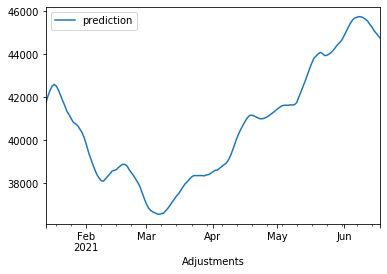

In [265]:
y_pred_df.plot()

In [266]:
y_test = sc.inverse_transform(y_test)

In [267]:
y_test_df = pd.DataFrame(y_test, columns=['actual'], index=test.index[:-12])

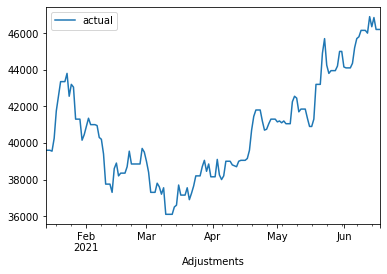

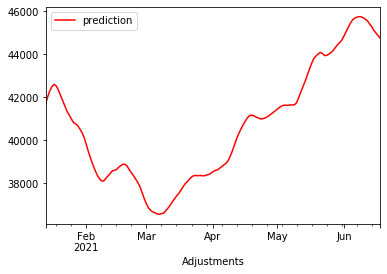

In [268]:
y_test_df.plot()
y_pred_df.plot(color = 'red')

In [269]:
MAE = mean_absolute_error(y_pred, y_test)
print('The Mean Absolute Error is: {}'.format(MAE))

The Mean Absolute Error is: 913.3038664410828
